In [20]:
import torch
import torchvision
import torchvision.transforms as transforms

In [21]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [22]:
import matplotlib.pyplot as plt
import numpy as np

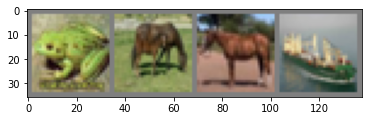

 frog horse horse  ship


In [23]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [34]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 150)
        self.fc2 = nn.Linear(150, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [35]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [36]:
for epoch in range(2):  # エポック数分ループを回します

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # データセットのデータを [inputs, labels]の形で取得
        inputs, labels = data

        # パラメータの勾配をリセット
        optimizer.zero_grad()

        # 順伝搬＋逆伝搬＋パラメータ更新
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 統計情報の表示
        running_loss += loss.item()
        if i % 2000 == 1999:    # 2,000ミニバッチにつき1度表示
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.230
[1,  4000] loss: 1.883
[1,  6000] loss: 1.698
[1,  8000] loss: 1.590
[1, 10000] loss: 1.514
[1, 12000] loss: 1.477
[2,  2000] loss: 1.399
[2,  4000] loss: 1.365
[2,  6000] loss: 1.332
[2,  8000] loss: 1.336
[2, 10000] loss: 1.288
[2, 12000] loss: 1.291
Finished Training


In [37]:
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

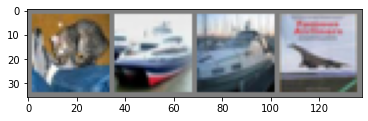

GroundTruth:    cat  ship  ship plane


In [38]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 画像と正解ラベルの表示
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [39]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [40]:
outputs = net(images)
outputs

tensor([[-1.6567, -1.9328,  0.1073,  2.2266, -0.1121,  2.1547,  0.5894,  0.1244,
         -1.1497, -1.6501],
        [ 5.1226,  6.2852, -2.6699, -3.6895, -3.7211, -4.5810, -4.9016, -4.3414,
          7.0763,  5.4804],
        [ 1.3649,  2.0667, -0.8532, -0.8849, -1.8338, -1.0822, -1.9457, -1.4576,
          2.3221,  2.4856],
        [ 2.0918,  0.8239,  0.0979, -0.5075, -1.2332, -2.0494, -2.0725, -1.8891,
          3.3533,  0.7855]], grad_fn=<AddmmBackward0>)

In [41]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship truck  ship


In [42]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [43]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 47 %
Accuracy of   car : 58 %
Accuracy of  bird : 45 %
Accuracy of   cat : 32 %
Accuracy of  deer : 26 %
Accuracy of   dog : 63 %
Accuracy of  frog : 63 %
Accuracy of horse : 56 %
Accuracy of  ship : 62 %
Accuracy of truck : 71 %
